In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
import numpy as np
import pickle
import torch
import matplotlib.pyplot as plt 
#from fase.core import heaan

from fase import HEAAN
from fase import HEAAN as he
from typing import List, Callable

from fase import hnrf as hnrf

from fase.hnrf.tree import NeuralTreeMaker
from fase.hnrf import heaan_nrf 
from fase.hnrf.hetree import HomomorphicModel 

#import importlib

Using CPU version HEAAN


In [3]:
def decrypt_print(ctx, n=20):
    res1 = decrypt(secretKey, ctx)
    print(res1[:n])
    
def decrypt(secretKey, enc):
    featurized = scheme.decrypt(secretKey, enc)
    arr = np.zeros(n, dtype=np.complex128)
    featurized.__getarr__(arr)
    return arr.real

def encrypt(val):
    ctxt = he.Ciphertext()#logp, logq, n)
    vv = np.zeros(n) # Need to initialize to zero or will cause "unbound"
    vv[:len(val)] = val
    scheme.encrypt(ctxt, he.Double(vv), n, logp, logq)
    del vv
    return ctxt

# Train a RF model  -- smaller example


In [ ]:
model_dir = "/home/hoseung/Work/fhenrf/pose/"

small = True

if small:
    fn_model_out = "./trained_model13_s.pickle"
    fn_data_out = "BBS_dataset_13s.pickle"
else:
    fn_model_out = "./trained_model13.pickle"
    fn_data_out = "BBS_dataset.pickle"

fn_model = model_dir + fn_model_out
fn_dat = model_dir + fn_data_out

rf_model = pickle.load(open(fn_model, "rb"))

print("model's depth:", rf_model.max_depth)
print("model's tree count:", rf_model.n_estimators)

### Train data

In [17]:
dataset = pickle.load(open(fn_dat, "rb"))

X_train = dataset["train_x"]
y_train = dataset["train_y"]
X_valid = dataset["valid_x"]
y_valid = dataset["valid_y"]

print("min max of input dataset")
print(X_train.min(), X_train.max())
print(X_valid.min(), X_valid.max())

min max of input dataset
0.0 1.0
0.0 1.0


# Convert RF to NRF

fastai를 안 쓰고싶지만, fastai가 훨씬 빠름.. 일단 사용하기로

In [18]:
from sklearn.tree import BaseDecisionTree
from fase.hnrf.tree import NeuralRF

dilatation_factor = 10
polynomial_degree = 10

estimators = rf_model.estimators_

my_tm_tanh = NeuralTreeMaker(torch.tanh, 
                            use_polynomial=True,
                            dilatation_factor=dilatation_factor, 
                            polynomial_degree=polynomial_degree)

Nmodel =NeuralRF(estimators, my_tm_tanh)

In [19]:
# NRF 성능 테스트
with torch.no_grad():
    neural_pred = Nmodel(torch.tensor(X_train).float()).argmax(dim=1).numpy()
    
pred = rf_model.predict(X_train)
print(f"Original accuracy : {(pred == y_train).mean()}")
print(f"Accuracy of tanh : {(neural_pred == y_train).mean()}")
print(f"Match between tanh and original : {(neural_pred == pred).mean()}")

Original accuracy : 0.9164629176854115
Accuracy of tanh : 0.26691116544417276
Match between tanh and original : 0.2766911165444173


## Fine tuning

In [20]:
from torch.utils import data

class TabularDataset(data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, X: np.ndarray, y: np.ndarray):
        'Initialization'
        self.X, self.y = X,y

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.X)

    def __getitem__(self, index):
        'Generates one sample of data'

        # Load data and get label
        X = torch.tensor(self.X[index]).float()
        y = torch.tensor(self.y[index])

        return X, y

In [21]:
bs = 128

train_ds = TabularDataset(X_train, y_train)
valid_ds = TabularDataset(X_valid, y_valid)

train_dl = data.DataLoader(train_ds, batch_size=bs, shuffle=True)
valid_dl = data.DataLoader(valid_ds, batch_size=bs)
fix_dl = data.DataLoader(train_ds, batch_size=bs, shuffle=False)

In [22]:
Nmodel.freeze_layer("comparator")
#Nmodel.freeze_layer("matcher")

for p in Nmodel.parameters():
    print(p.shape, p.requires_grad)

torch.Size([180, 57, 20]) False
torch.Size([57, 20]) False
torch.Size([58, 57, 20]) True
torch.Size([58, 20]) True
torch.Size([5, 58, 20]) True
torch.Size([5, 20]) True


In [23]:
import fastai
print(fastai.__version__)

from fastai.basic_data import DataBunch
from fastai.tabular.learner import Learner
from fastai.metrics import accuracy

from fase.hnrf.tree import CrossEntropyLabelSmoothing
import torch.nn as nn

data = DataBunch(train_dl, valid_dl, fix_dl=fix_dl)

criterion = CrossEntropyLabelSmoothing()

learn = Learner(data, Nmodel, loss_func=criterion, metrics=accuracy)

1.0.61


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


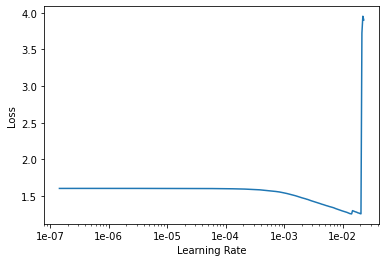

In [24]:
learn.lr_find(num_it=500)
learn.recorder.plot()

In [25]:
learn.fit_one_cycle(20, 0.007)

epoch,train_loss,valid_loss,accuracy,time
0,1.591383,1.570926,0.338107,00:00
1,1.549512,1.469579,0.374956,00:00
2,1.455572,1.273944,0.495809,00:00
3,1.349527,1.157706,0.625393,00:00
4,1.257134,1.057593,0.695075,00:00
5,1.172213,0.987498,0.732623,00:00
6,1.093307,0.968403,0.763185,00:00
7,1.030469,0.898143,0.787635,00:00
8,0.974793,0.868988,0.800210,00:00
9,0.926722,0.852492,0.800908,00:00


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


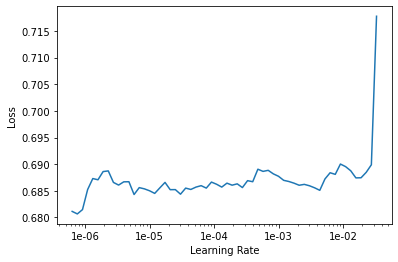

In [26]:
learn.lr_find(num_it=100)
learn.recorder.plot()

In [27]:
learn.fit_one_cycle(50, 0.0002)

epoch,train_loss,valid_loss,accuracy,time
0,0.687498,0.744280,0.915299,00:00
1,0.687814,0.744088,0.915473,00:00
2,0.685797,0.743886,0.915473,00:00
3,0.685312,0.743631,0.914775,00:00
4,0.684955,0.743308,0.914251,00:00
5,0.683095,0.743058,0.913902,00:00
6,0.683722,0.742458,0.914076,00:00
7,0.684799,0.742210,0.913378,00:00
8,0.685810,0.741970,0.915648,00:00
9,0.683528,0.740803,0.915997,00:00


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


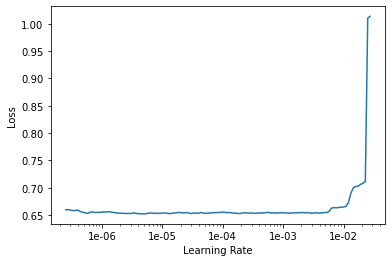

In [28]:
learn.lr_find(num_it=200)
learn.recorder.plot()

In [29]:
learn.fit_one_cycle(100, 0.2)

epoch,train_loss,valid_loss,accuracy,time
0,0.707028,1.975916,0.926650,00:00
1,1.429882,2.249321,0.899581,00:00
2,2.706462,18.882061,0.852602,00:00
3,6.192741,7.454208,0.751834,00:00
4,19.953732,21.945232,0.670800,00:00
5,51.170341,196.576279,0.532483,00:00
6,568.715210,3648.638428,0.426301,00:00
7,16375.170898,34168.292969,0.449354,00:00
8,398794.250000,25700190.000000,0.364303,00:00
9,6911565.500000,8013332.000000,0.322389,00:00


In [30]:
learn.fit_one_cycle(100, 0.1)

epoch,train_loss,valid_loss,accuracy,time
0,1700.429565,2908.354492,0.517639,00:00
1,1807.756958,2839.207275,0.516242,00:00
2,1769.033691,2766.233154,0.520957,00:00
3,1687.184082,2626.439453,0.520608,00:00
4,1627.232666,2466.593018,0.512050,00:00
5,1570.300903,2244.401367,0.513273,00:00
6,1508.773193,1919.781372,0.512225,00:00
7,1420.119141,2051.041504,0.497206,00:00
8,2308.908203,1751.841797,0.519211,00:00
9,2275.080078,5421.272461,0.489521,00:00


In [31]:
learn.fit_one_cycle(100, 0.02)

epoch,train_loss,valid_loss,accuracy,time
0,240.479599,299.567810,0.502445,00:00
1,243.777466,283.481689,0.503667,00:00
2,242.270355,296.399872,0.509605,00:00
3,241.320663,276.581390,0.501746,00:00
4,232.002808,914.199097,0.498254,00:00
5,282.691650,379.900238,0.510304,00:00
6,297.007660,394.712067,0.511876,00:00
7,287.643066,337.160187,0.505065,00:00
8,270.843079,303.092224,0.495459,00:00
9,250.772369,437.802399,0.503144,00:00


In [32]:
#learn.fit_one_cycle(100, 0.5)
#learn.fit_one_cycle(100, 0.05)
learn.fit_one_cycle(100, 0.001)

epoch,train_loss,valid_loss,accuracy,time
0,0.648342,0.769276,0.974328,00:00
1,0.645012,0.767536,0.974153,00:00
2,0.642446,0.765548,0.973804,00:00
3,0.642133,0.763057,0.973978,00:00
4,0.641647,0.759126,0.973804,00:00
5,0.641527,0.758215,0.971359,00:00
6,0.639235,0.745242,0.974328,00:00
7,0.636291,0.735637,0.975550,00:00
8,0.631660,0.723130,0.974677,00:00
9,0.626082,0.728148,0.972756,00:00


## Fine-tuned NRF model

In [33]:
pred = rf_model.predict(X_valid)

with torch.no_grad():
    neural_pred = Nmodel(torch.tensor(X_valid).float()).argmax(dim=1).numpy()

print(f"Original accuracy : {(pred == y_valid).mean()}")
print(f"Accuracy : {(neural_pred == y_valid).mean()}")
print(f"Same output : {(neural_pred == pred).mean()}")

Original accuracy : 0.9100593782745372
Accuracy : 0.991617184771219
Same output : 0.9025497729654209


# 0. HEAAN context

In [34]:
class Param():
    def __init__(self, n=None, logn=None, logp=None, logq=None, logQboot=None):
        self.n = n
        self.logn = logn
        self.logp = logp
        self.logq = logq 
        self.logQboot = logQboot
        if self.logn == None:
            self.logn = int(np.log2(n))

In [35]:
logq = 540
logp = 30
logn = 14
n = 1*2**logn
slots = n

parms = Param(n=n, logp=logp, logq=logq)

do_reduction=False


ring = he.Ring()
secretKey = he.SecretKey(ring)
scheme = he.Scheme(secretKey, ring, False)

algo = he.SchemeAlgo(scheme)


# reduction때는 right rotation N_class개 필요. 
if do_reduction:
    Nclass = Nmodel.head.shape[0]
    scheme.addLeftRotKeys(secretKey)
    for i in range(Nclass):
        scheme.addRightRotKey(secretKey, i+1) # 
else:
    # reduction 안 하면 하나짜리 rotation만 여러번 반복.
    scheme.addLeftRotKey(secretKey, 1)

### Neural RF

In [36]:
from fase.hnrf.hetree import HNRF
h_rf = HNRF(Nmodel)

nrf_evaluator = heaan_nrf.HETreeEvaluator.from_model(h_rf,
                                                    scheme,
                                                    parms,
                                                    my_tm_tanh.coeffs,
                                                    do_reduction = do_reduction
                                                    )

CKKS paramters:
---------------------------
n = 16384
logp = 30
logq = 540
tanh activation polynomial coeffs = [-1.091930e-15  4.758149e+00  8.553133e-14 -1.838215e+01 -8.061430e-13  3.860479e+01  2.488191e-12 -3.728043e+01
 -3.043707e-12  1.331208e+01  1.281561e-12]
tanh activation polynomial degree = 10

Neural RF
---------------------------



In [37]:
featurizer = heaan_nrf.HETreeFeaturizer(h_rf.return_comparator(), scheme, parms)



In [38]:
from time import time

In [39]:
for xx, yy in zip(X_valid, y_valid):
    ctx = featurizer.encrypt(xx)
    t0 = time()
    result = nrf_evaluator(ctx)
    print(f"Took {time() - t0:.2f} seconds")

    pred = []
    for res in result:
        dec = decrypt(secretKey, res)
        pred.append(np.sum(dec))

    print(f"Prediction: {np.argmax(pred)} == {yy}?")

Took 434.54 seconds
Prediction: 3 == 3?
Took 429.60 seconds
Prediction: 4 == 4?
Took 430.15 seconds
Prediction: 2 == 2?
Took 429.40 seconds
Prediction: 2 == 2?
Took 433.07 seconds
Prediction: 2 == 2?
Took 429.98 seconds
Prediction: 4 == 4?


KeyboardInterrupt: 

여기서 만든 h_rf와 새로 만든 h_rf의 모양, 값 차이 비교